In [2]:
## Creat segements and save
import sys
from pathlib import Path
import wfdb
import pandas as pd
from pprint import pprint

database_name = 'mimic4wdb/0.1.0'
subjects = wfdb.get_record_list(database_name)
print(f"The '{database_name}' database contains data from {len(subjects)} subjects")
max_records_to_load = 10000

# iterate the subjects to get a list of records
records = []
for subject in subjects:
    studies = wfdb.get_record_list(f'{database_name}/{subject}')
    for study in studies:
        records.append(Path(f'{subject}{study}'))
        # stop if we've loaded enough records
    if len(records) >= max_records_to_load:
        print("Reached maximum required number of records.")
        break

print(f"Loaded {len(records)} records from the '{database_name}' database.")

# format and print first five records
first_five_records = [str(x) for x in records[0:5]]
first_five_records = "\n - ".join(first_five_records)
print(f"First five records: \n - {first_five_records}")

print("""
Note the formatting of these records:
 - intermediate directory ('p100' in this case)
 - subject identifier (e.g. 'p10014354')
 - record identifier (e.g. '81739927'
 """)

# Specify the 4th record (note, in Python indexing begins at 0)
idx = 3
record = records[idx]
record_dir = f'{database_name}/{record.parent}'
print("PhysioNet directory specified for record: {}".format(record_dir))

record_name = record.name
print("Record name: {}".format(record_name))

record_data = wfdb.rdheader(record_name, pn_dir=record_dir, rd_segments=True)
remote_url = "https://physionet.org/content/" + record_dir + "/" + record_name + ".hea"
print(f"Done: metadata loaded for record '{record_name}' from the header file at:\n{remote_url}")
print(f"- Number of signals: {record_data.n_sig}".format())
print(f"- Duration: {record_data.sig_len/(record_data.fs*60*60):.1f} hours") 
print(f"- Base sampling frequency: {record_data.fs} Hz")
segments = record_data.seg_name
print(f"The {len(segments)} segments from record {record_name} are:\n{segments}")

segment_metadata = wfdb.rdheader(record_name=segments[2], pn_dir=record_dir)

print(f"""Header metadata loaded for: 
- the segment '{segments[1]}'
- in record '{record_name}'
- for subject '{str(Path(record_dir).parent.parts[-1])}'
""")
print(f"This segment contains the following signals: {segment_metadata.sig_name}")
print(f"The signals are measured in units of: {segment_metadata.units}")
print(f"The signals have a base sampling frequency of {segment_metadata.fs:.1f} Hz")
print(f"and they last for {segment_metadata.sig_len/(segment_metadata.fs*60):.1f} minutes")
print(f"Earlier, we loaded {len(records)} records from the '{database_name}' database.")

required_sigs = ['ABP', 'Pleth']
# convert from minutes to seconds
time_length = 10 # min
req_seg_duration = time_length*60 

matching_recs = {'dir':[], 'seg_name':[], 'length':[]}

for record in records:
    print('Record: {}'.format(record), end="", flush=True)
    record_dir = f'{database_name}/{record.parent}'
    record_name = record.name
    print(' (reading data)')
    record_data = wfdb.rdheader(record_name,
                                pn_dir=record_dir,
                                rd_segments=True)

    # Check whether the required signals are present in the record
    sigs_present = record_data.sig_name
    if not all(x in sigs_present for x in required_sigs):
        print('   (missing signals)')
        continue

    # Get the segments for the record
    segments = record_data.seg_name

    # Check to see if the segment is 10 min long
    # If not, move to the next one
    gen = (segment for segment in segments if segment != '~')
    for segment in gen:
        print(' - Segment: {}'.format(segment), end="", flush=True)
        segment_metadata = wfdb.rdheader(record_name=segment,
                                         pn_dir=record_dir)
        seg_length = segment_metadata.sig_len/(segment_metadata.fs)

        if seg_length < req_seg_duration:
            print(f' (too short at {seg_length/60:.1f} mins)')
            continue

        # Next check that all required signals are present in the segment
        sigs_present = segment_metadata.sig_name
        
        if all(x in sigs_present for x in required_sigs):
            matching_recs['dir'].append(record_dir)
            matching_recs['seg_name'].append(segment)
            matching_recs['length'].append(seg_length)
            print(' (met requirements)')
            # Since we only need one segment per record break out of loop
            break
        else:
            print(' (long enough, but missing signal(s))')

print(f"A total of {len(matching_recs['dir'])} records met the requirements: longer than {time_length}mins")

df_matching_recs = pd.DataFrame(data=matching_recs)
df_matching_recs.to_csv(f'/Users/jinyanwei/Desktop/BP_Model/Data/mimic4wdf/matching_records_{time_length}mins.csv', index=False)
#p=1

print(f"A total of {len(matching_recs['dir'])} out of {len(records)} records met the requirements.")

relevant_segments_names = "\n - ".join(matching_recs['seg_name'])
print(f"\nThe relevant segment names are:\n - {relevant_segments_names}")

relevant_dirs = "\n - ".join(matching_recs['dir'])
print(f"\nThe corresponding directories are: \n - {relevant_dirs}")

The 'mimic4wdb/0.1.0' database contains data from 198 subjects
Loaded 200 records from the 'mimic4wdb/0.1.0' database.
First five records: 
 - waves/p100/p10014354/81739927/81739927
 - waves/p100/p10019003/87033314/87033314
 - waves/p100/p10020306/83404654/83404654
 - waves/p100/p10039708/83411188/83411188
 - waves/p100/p10039708/85583557/85583557

Note the formatting of these records:
 - intermediate directory ('p100' in this case)
 - subject identifier (e.g. 'p10014354')
 - record identifier (e.g. '81739927'
 
PhysioNet directory specified for record: mimic4wdb/0.1.0/waves/p100/p10039708/83411188
Record name: 83411188
Done: metadata loaded for record '83411188' from the header file at:
https://physionet.org/content/mimic4wdb/0.1.0/waves/p100/p10039708/83411188/83411188.hea
- Number of signals: 6
- Duration: 14.2 hours
- Base sampling frequency: 62.4725 Hz
The 6 segments from record 83411188 are:
['83411188_0000', '83411188_0001', '83411188_0002', '83411188_0003', '83411188_0004', '83

Specified segment '82924339_0007' in directory: 'mimic4wdb/0.1.0/waves/p101/p10126957/82924339'
Metadata loaded from segment: 82924339_0007
60 seconds of data extracted from segment 82924339_0007


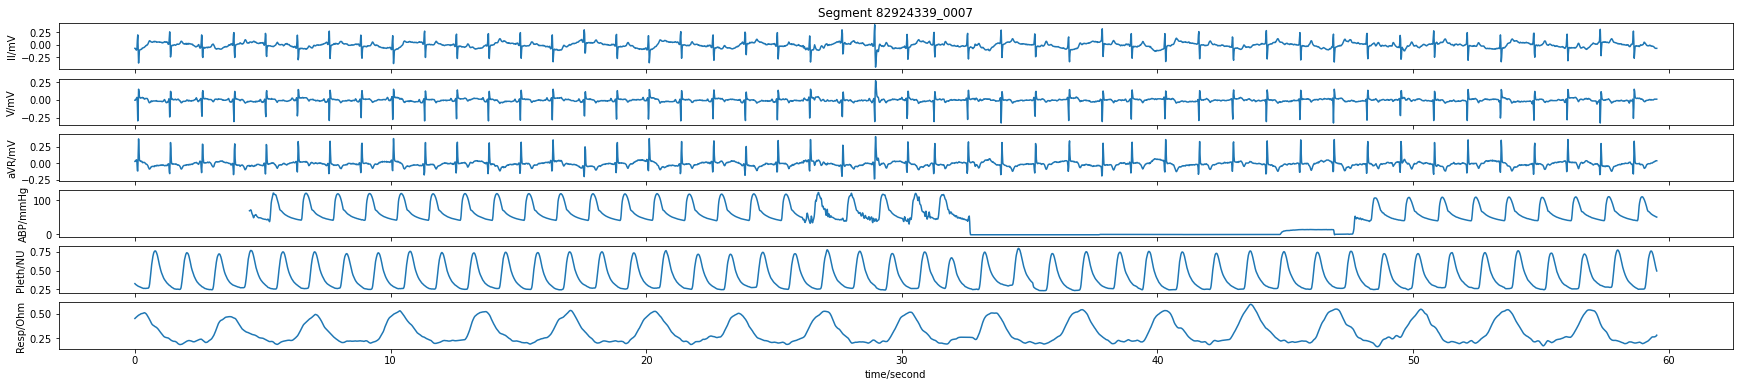

Extracted the PPG signal from column 4 of the matrix of waveform data.


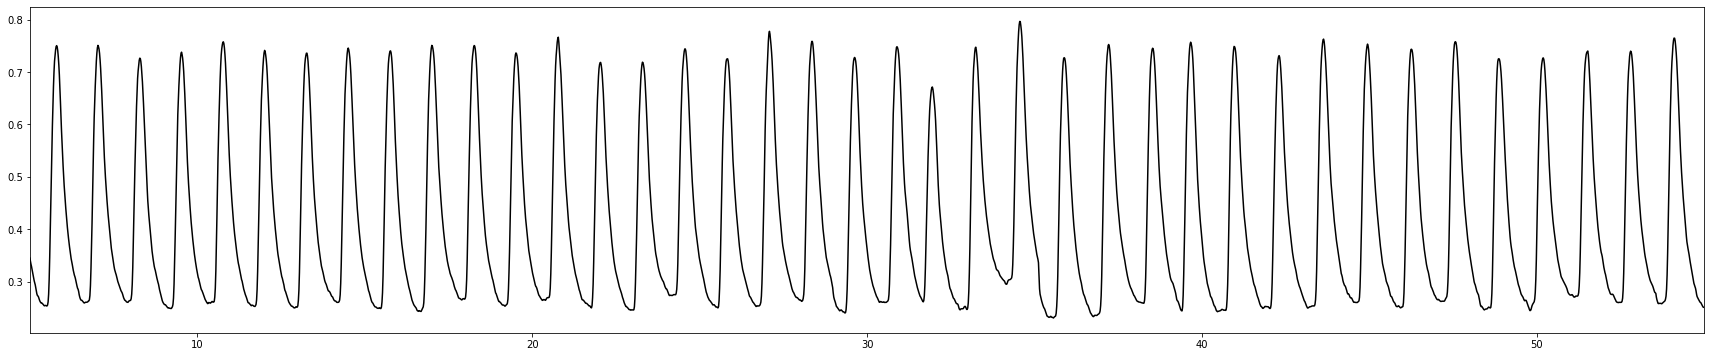

In [1]:
import sys
from pathlib import Path
import wfdb

# The name of the MIMIC IV Waveform Database on PhysioNet
database_name = 'mimic4wdb/0.1.0'
segment_names = ['83404654_0005', '82924339_0007']
segment_dirs = ['mimic4wdb/0.1.0/waves/p100/p10020306/83404654',
                'mimic4wdb/0.1.0/waves/p101/p10126957/82924339']

rel_segment_n = 1
rel_segment_name = segment_names[rel_segment_n]
rel_segment_dir = segment_dirs[rel_segment_n]
print(f"Specified segment '{rel_segment_name}' in directory: '{rel_segment_dir}'")

# time since the start of the segment at which to begin extracting data
start_seconds = 0
n_seconds_to_load = 60
segment_metadata = wfdb.rdheader(record_name=rel_segment_name,
                                 pn_dir=rel_segment_dir)

print(f"Metadata loaded from segment: {rel_segment_name}")
fs = round(segment_metadata.fs)
sampfrom = fs * start_seconds
sampto = fs * (start_seconds + n_seconds_to_load)

segment_data = wfdb.rdrecord(record_name=rel_segment_name,
                             sampfrom=sampfrom,
                             sampto=sampto,
                             pn_dir=rel_segment_dir)

print(f"{n_seconds_to_load} seconds of data extracted from segment {rel_segment_name}")

title_text = f"Segment {rel_segment_name}"
wfdb.plot_wfdb(record=segment_data,
               title=title_text,
               time_units='seconds', figsize=(30,6)) 

for sig_no in range(0, len(segment_data.sig_name)):
    if "Pleth" in segment_data.sig_name[sig_no]:
        break
ppg = segment_data.p_signal[:, sig_no]
fs = segment_data.fs
print(f"Extracted the PPG signal from column {sig_no} of the matrix of waveform data.")

from matplotlib import pyplot as plt
import numpy as np

t = np.arange(0, (len(ppg) / fs), 1.0 / fs)
fig = plt.figure(figsize=[30,6])
plt.plot(t[:len(ppg)], ppg, color = 'black', label='PPG')
plt.xlim([5, 55])
plt.show()